**DATA 562 - Project**  
SLO Data Analysis  
K. VanderLinden  
Spring 2024  

This report analyzes the nature of the SLO data with respect to the SLO stance-detection project. It investigates tweet properties (e.g.: time series; re-tweets; users) and linguistic characteristics of the tweet texts (e.g.: character/word counts/frequencies; hashtags; mentions; stock symbols; URLs).

Parts of this analysis are based on an original analysis S. Yada, CSIRO, Spring 2018.

In [8]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pathlib import Path
DATA_DIR = Path('../data')
SRC_DIR = Path('../src')

sys.path.append(str(SRC_DIR))
import settings as settings


## Load the Data

We load a version of the data that has been pre-processed from the raw tweet data but not normalized. The pre-processing comprised reading the JSON dump from the Twitter feed and dropping tweets that either don&rsquo;t mention mining companies or weren&rsquo;t written in English.

In [9]:
df = pd.read_csv(Path(DATA_DIR, 'dataset.csv'), parse_dates=['created_at'])
df

,id,created_at,lang,lang_polyglot,retweeted,hashtags,company,text,user_screen_name,user_description
0,305160140833816576,2013-02-23 03:40:21+00:00,en,en,False,NaN,adani,@abcnews About bloody time. Adani only wants F...,DazzDicko,"Train Driver extraordinaire, proud Union Lefti..."
1,308566294544920576,2013-03-04 13:15:12+00:00,en,en,False,NaN,adani,This is something what we call a true Indian. ...,KuchLafz,à¤¤à¥à¤®à¥à¤¹à¥à¤ à¤à¤²à¥à¤«à¤¼à¤¤ à¤¨à¤...
2,308567546871832576,2013-03-04 13:20:10+00:00,en,en,False,NaN,adani,Please RT This is something what we call a tru...,KuchLafz,à¤¤à¥à¤®à¥à¤¹à¥à¤ à¤à¤²à¥à¤«à¤¼à¤¤ à¤¨à¤...
3,308574326507061248,2013-03-04 13:47:07+00:00,en,en,False,lulz,adani,"Modi dropped from Wharton event, Gautam Adani ...",Great_Gujarati,"M.Sc(IT), MIT, MCSE - BI | Yoga, Pranayam, Med..."
4,308724450147319808,2013-03-04 23:43:39+00:00,en,en,False,NaN,adani,Adani's Corrupt History is No Obstacle for New...,erlandh,"Graphic designer, photographer & facilitator. ..."
...,...,...,...,...,...,...,...,...,...,...
485405,994032429630242816,2018-05-09 01:52:54+00:00,en,en,False,HRConnect18,woodside,Hey @awils here's some feedback from the highl...,wombling,"SAP Mentor, SAP HR Technical specialist, Engli..."
485406,994039219818500102,2018-05-09 02:19:53+00:00,en,en,False,hrconnect18,woodside,Great insights shared by Adrienne Viney from W...,russellmporter,NaN
485407,994040211628875776,2018-05-09 02:23:49+00:00,en,en,False,hrconnect18,woodside,"“The system just works, it’s there and does wh...",russellmporter,NaN
485408,994064187025436672,2018-05-09 03:59:05+00:00,en,en,True,NaN,woodside,RT @FOLLOW_DA_BUCKS: 0 @ETUVIC happened in ...,TaraNipe,"A literate, pragmatic, Lefty feminist activist..."


## Analysis

### Data Skew

We start by looking at the relative numbers of tweets that mention the different mining companies we&rsquo;ve chosen to follow.

In [10]:
company_df = pd.DataFrame(settings.full_company_list, columns=['company'])
company_df['count'] = company_df['company'].apply(lambda x: df['company'].str.contains(x).sum())

company_df[['company', 'count']].sort_values(by='count', ascending=False)

,company,count
0,adani,296640
8,santos,63888
1,bhp,61010
7,riotinto,25943
10,woodside,14436
9,whitehaven,11633
3,fortescue,11404
4,iluka,3050
6,oilsearch,1979
5,newmont,868


Here we see a dataset clearly skewed toward comments on Adani Group.

In [11]:
company_df['count'].sum()

490984

Here, we see that the sum of the mentions is greater than the original number of tweets (see above). This is because some Tweets mention more than one company.

In [12]:
df.loc[df['company'].str.contains('\|'), ['company', 'text']]

,company,text
60,adani|bhp,BHP drops Abbot Pt #coal terminal! GVK and Ada...
61,adani|bhp,RT @market_forces: BHP drops Abbot Pt #coal te...
63,adani|bhp,RT @market_forces: BHP drops Abbot Pt #coal te...
87,adani|bhp,GVK cancel rail line; Adani has financial woes...
1852,adani|bhp,Minerals Council of Australia produced these. ...
...,...,...
485066,bhp|woodside,"BHP, Rio, CBA, Woodside, NAB face dividend pay..."
485075,bhp|woodside,RT @Stevesage13: 0 @BCAcomau @bhp @woolwort...
485077,bhp|woodside,RT @Stevesage13: 0 @BCAcomau @bhp @woolwort...
485122,bhp|riotinto|woodside,"Macquarie Group and South32 dropped 1.2%, ANZ ..."


### Time Series

Tweets are made over time, and the dataset includes timestamps.

<Axes: xlabel='created_at'>

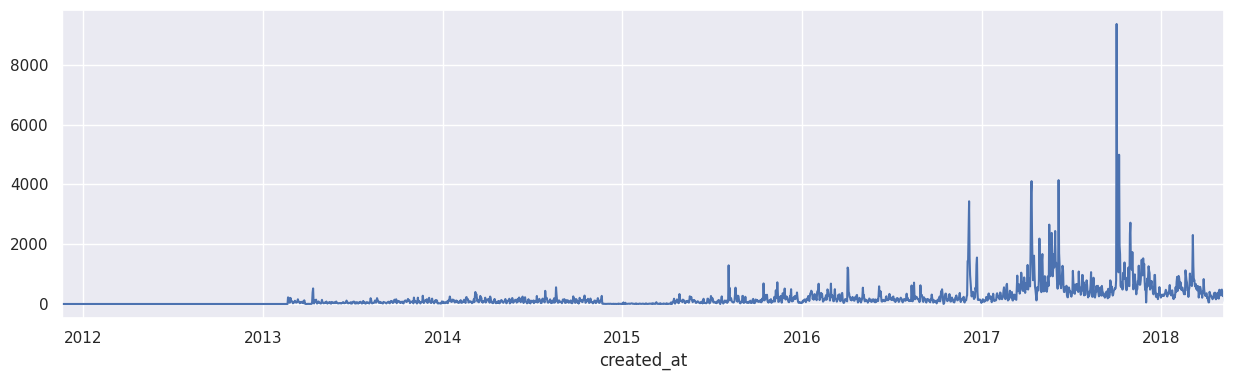

In [13]:
def resample_daily_counts(df):
    return df['created_at'].value_counts().resample('1D').sum()

resample_daily_counts(df).plot(figsize=(15, 4))

Given this, we could consider using time-series techniques for the data analysis.

We&rsquo;ll now filter out the relatively few tweets posted before 2013 (only 2) and also remove those tweets with multiple company designations (~5K, see above).

In [14]:
# Remove multi-company tweets.
ts_df = df[~df['company'].str.contains('\|')] # & ~df['created_at'].str.contains('2010|2011|2012')]

# Remove tweets before 2013.
ts_df = ts_df.loc[ts_df['created_at'] > pd.to_datetime('2013-01-01 00:00:00+00:00')]

ts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480196 entries, 0 to 485409
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   id                480196 non-null  int64              
 1   created_at        480196 non-null  datetime64[ns, UTC]
 2   lang              480196 non-null  object             
 3   lang_polyglot     480196 non-null  object             
 4   retweeted         480196 non-null  bool               
 5   hashtags          267573 non-null  object             
 6   company           480196 non-null  object             
 7   text              480196 non-null  object             
 8   user_screen_name  480196 non-null  object             
 9   user_description  450209 non-null  object             
dtypes: bool(1), datetime64[ns, UTC](1), int64(1), object(7)
memory usage: 37.1+ MB


We now look at the tweets over time for different companies.

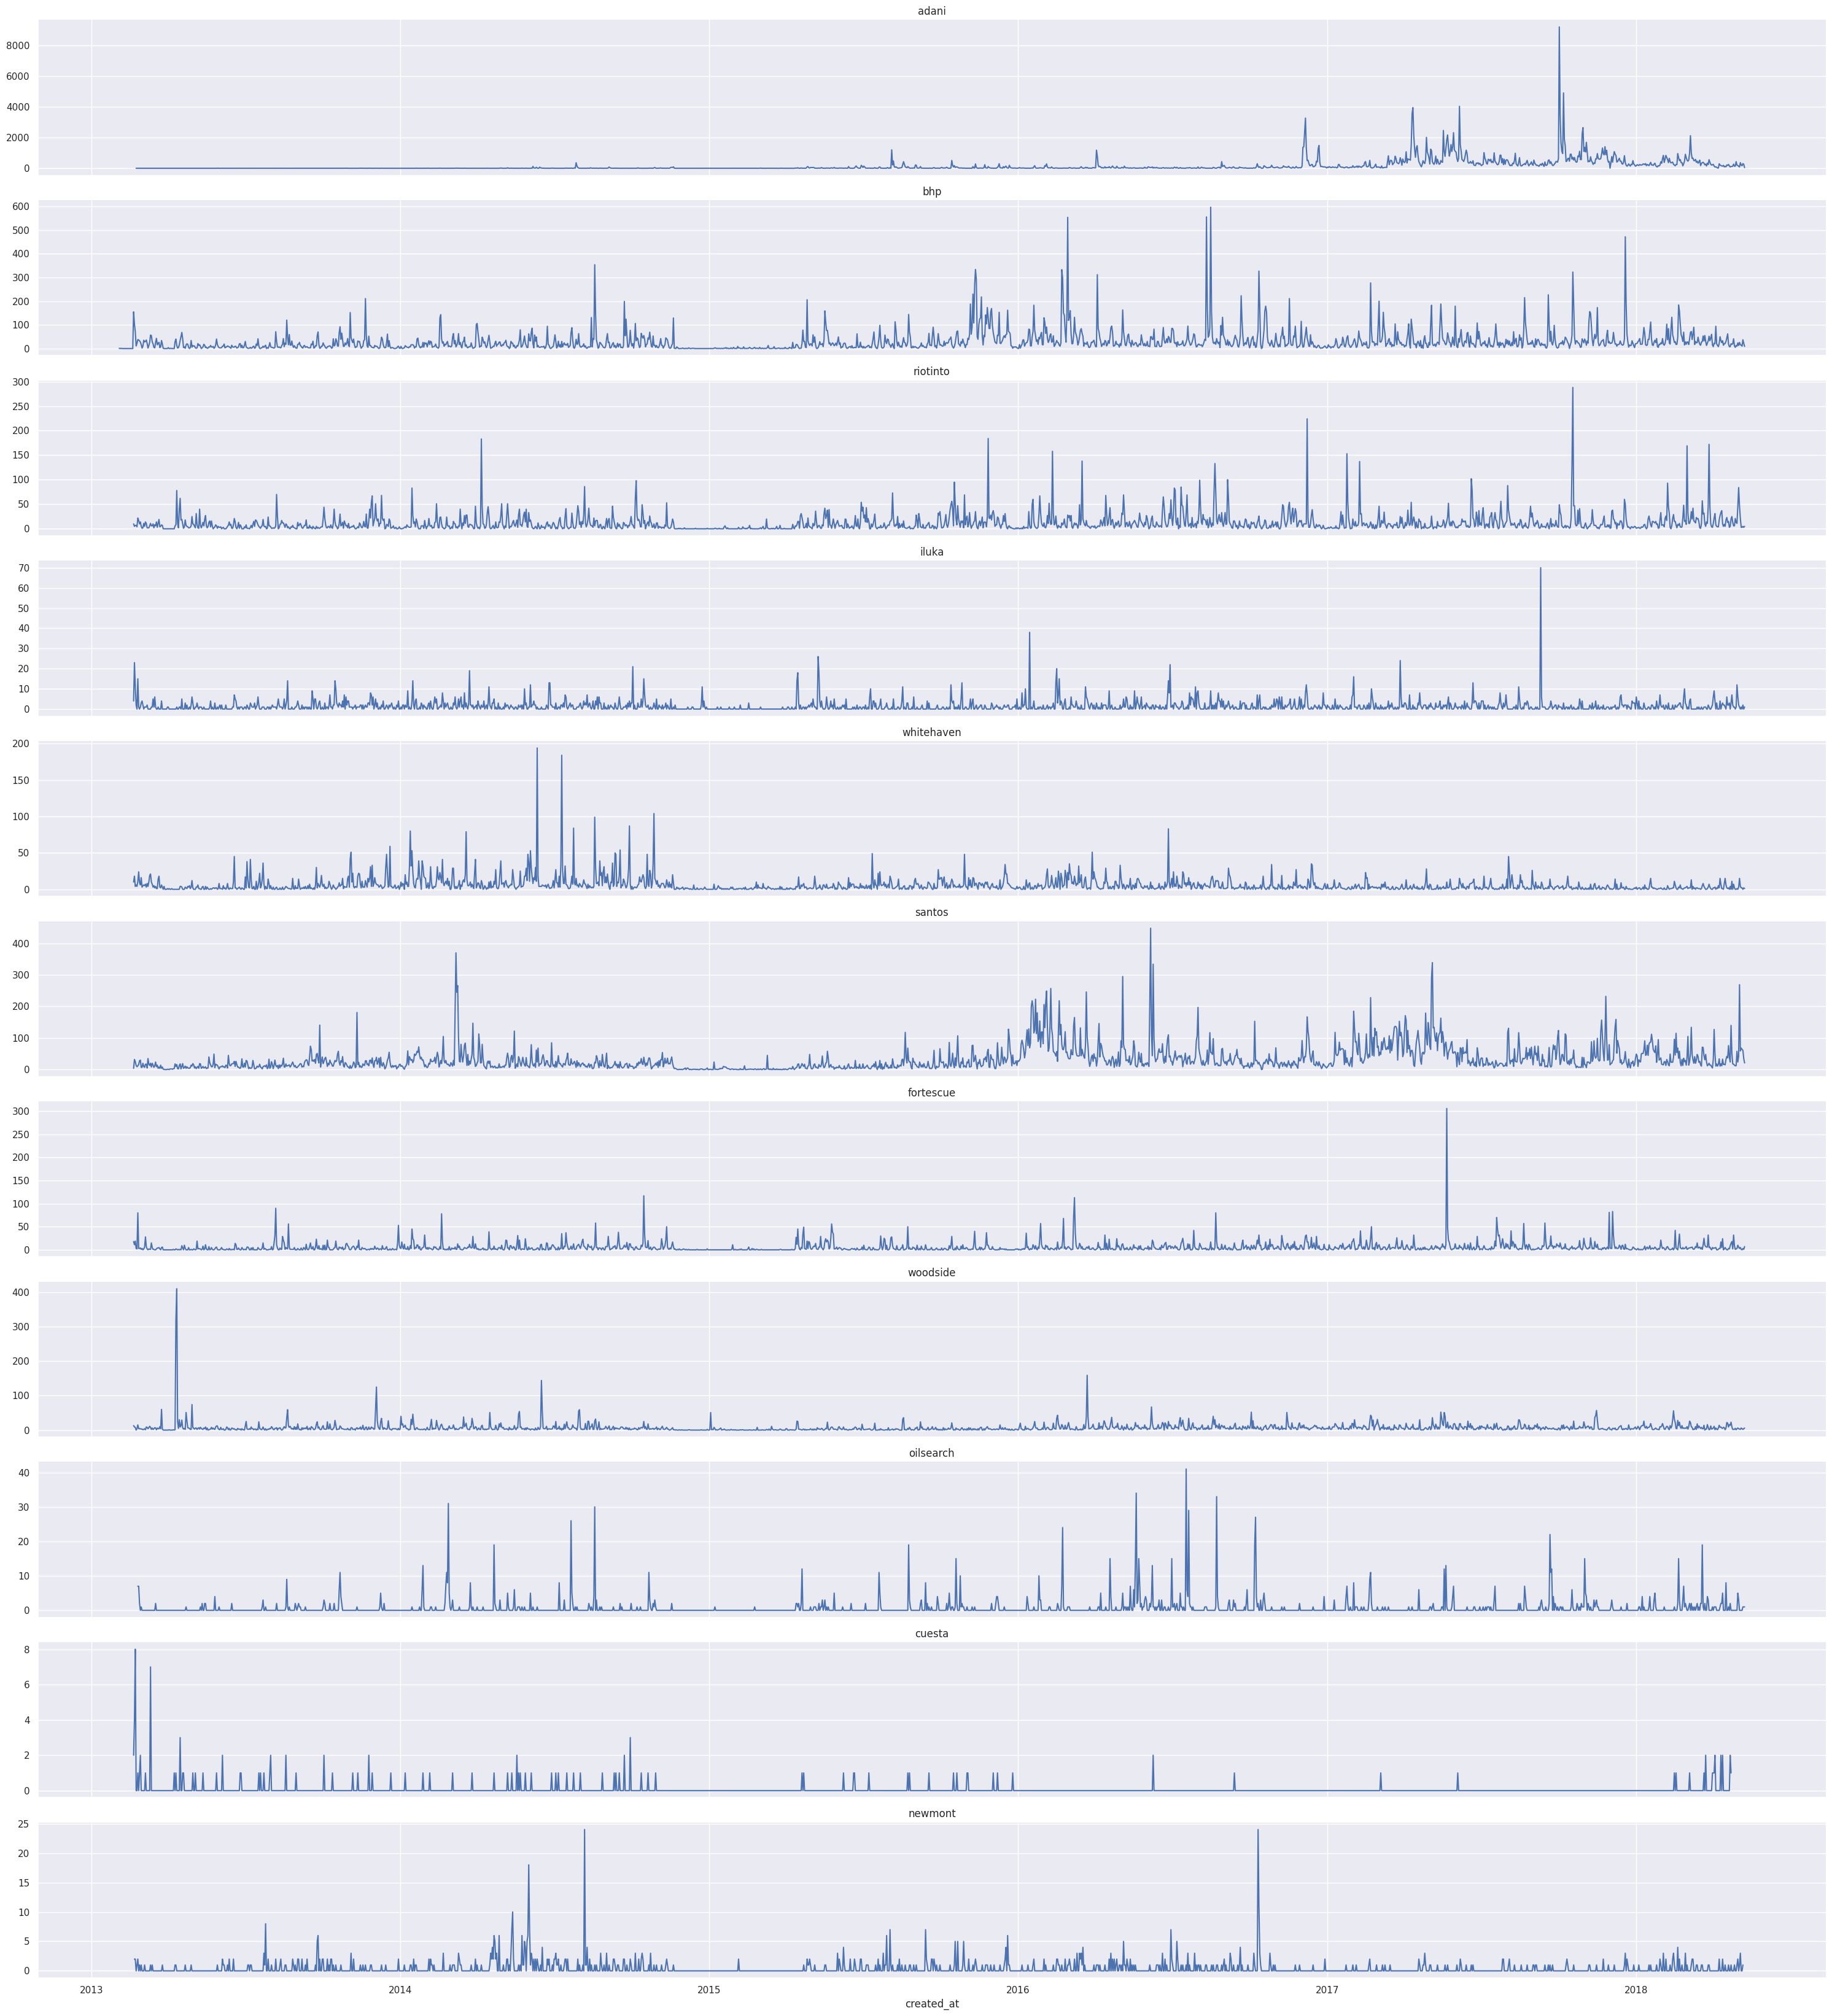

In [15]:
def ts_plot(col, **kwargs):
    plt.gca().plot(
        resample_daily_counts(
            kwargs.pop('data')
            )
        )

grid = sns.FacetGrid(ts_df[['created_at', 'company']], row='company', aspect=10, sharey=False)
grid.map_dataframe(ts_plot, 'created_at').set_titles('{row_name}')

The peaks in these company-specific graphs differ, which is likely because company-specific events occur at different times. Identifying these times and stance of users regarding the company in question will be key to the stance detection project.

## Re-Tweets

Some tweets are simply repeats of earlier tweets.

In [16]:
df['retweeted'].value_counts()

retweeted
True     264446
False    220964
Name: count, dtype: int64

Roughly half the tweets are retweets. We&rsquo;ll need to consider whether or not to include retweets in the analysis.

### Users

We now consider the users who make the tweets.

In [17]:
df['user_screen_name'].value_counts().value_counts(normalize=True).head(10)

count
1     0.491850
2     0.147324
3     0.071395
4     0.044218
5     0.030466
6     0.022731
7     0.017160
8     0.013633
9     0.012240
10    0.010462
Name: proportion, dtype: float64

Roughly half of the users have tweeted only once in the dataset.

Because some users tweet more often, it may be worth normalizing the user profile texts into a separate dataset.

### Lexical Characteristics of the Data

We now consider the words and their distributions.

In [28]:
import nltk
from nltk.tokenize.casual import TweetTokenizer
from nltk.probability import FreqDist

# Tokenize the tweets and the user profile descriptions.
tokenizer = TweetTokenizer()
df['text_tokenized'] = df['text'].apply(tokenizer.tokenize)
df['user_description_tokenized'] = df['user_description'].dropna().apply(tokenizer.tokenize)

# Count the number of words and unique words.
tokens = \
    [token for text in df['text_tokenized'] for token in text] + \
    [token for text in df['user_description_tokenized'].dropna() for token in text]
unique_tokens = set(tokens)
print(f'Total Words: {len(tokens)}')
print(f'Unique Words: {len(unique_tokens)}')

Total Words: 18654320
Unique Words: 378493


We will need to deal with a large number of words in this tweet dataset.

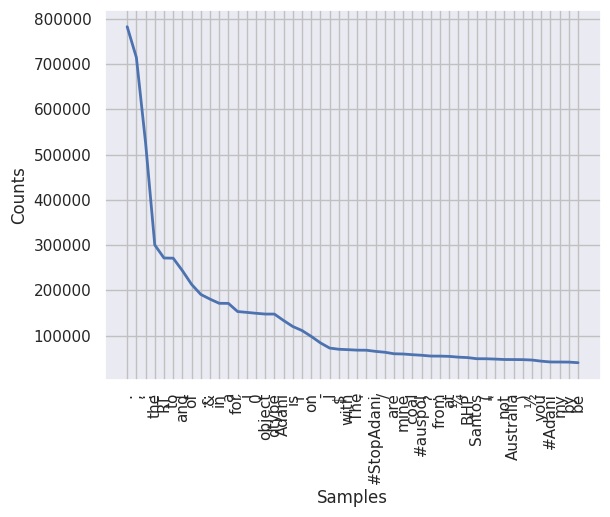

<Axes: xlabel='Samples', ylabel='Counts'>

In [20]:
common_tokens = nltk.FreqDist(tokens)
common_tokens.plot(50, cumulative=False)

The common words include some unusual ones (e.g., `#StopAdani`).

Here, we collect the unusual words, where unusual is defined as not being in the dictionary used by Glove.

In [27]:
import random

glove_words = set([line.split(' ', 1)[0] for line in open(Path(DATA_DIR, 'glove.6B.50d.txt'))])
len(glove_words)

uncommon_tokens = unique_tokens - glove_words
random.sample(uncommon_tokens, 20)

# uncommon_tokens = [token for token in unique_tokens if token not in words.words()]
# uncommon_tokens

/tmp/ipykernel_73087/2303503028.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(uncommon_tokens, 20)


['https://t.co/becqbF0eQO',
 'https://t.co/73qwRrNw7o',
 'https://t.co/AiR4RHp1EM',
 'Lindy',
 '398pts',
 'westpack',
 'https://t.co/4lDLtCesNE',
 'http://t.co/1BdHKKAJzl',
 'https://t.co/64jYjKLIdH',
 'http://t.co/0qf4M1brWt',
 'TradÂ',
 'Humorizer',
 'https://t.co/aWYluFVIVh',
 '#StopAdaniGeelo',
 '@EarthBeauties',
 'https://t.co/iX0pn2hbfh',
 '@NIBS_TradesHall',
 '#stopspecialtreatment',
 '@Richmond_FC',
 'Junket']